# Backtesting an ML strategy with Backtrader

## Imports & Settings

In [1]:
import warnings
import datetime

from backtrader_plotting import Bokeh, OptBrowser
from tqdm import tqdm

warnings.filterwarnings('ignore')

Loading BokehJS ...

In [2]:
# %matplotlib inline

from pathlib import Path
import csv
from time import time
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns

import backtrader as bt
from backtrader.feeds import PandasData

import pyfolio as pf


In [3]:
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)
sns.set_style('darkgrid')

In [4]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

## Backtrader Setup

### Custom Commission Scheme

In [5]:
# https://www.backtrader.com/blog/posts/2019-08-29-fractional-sizes/fractional-sizes/
# https://medium.com/@gk_/crypto-quant-programmatic-trading-of-btc-using-binance-and-backtrader-part-2-of-3-d8af44c93e2b
class CommInfoFractional(bt.CommissionInfo):
    params = dict(stocklike=True,
                  commission=.0075,
                  commtype = bt.CommInfoBase.COMM_PERC)# No margin, no multiplier
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)


### DataFrame Loader


class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    OHLCV = ['open', 'high', 'low', 'close', 'volume']
    cols = OHLCV + ['predicted']

    # create linesReceives a timer notification where timer is the timer which was returned by add_timer, and when is the calling time. args and kwargs are any additional arguments passed to add_timer
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

### Create and Configure Cerebro Instance

### Add input data


In [6]:
def get_eval_data(results_path = 'results_D_144_ncut_1yrs/', offset=0):
    factors = (pd.read_feather(results_path +'test_preds.ftr').set_index(['date', 'offset', 'ticker'])
                   .loc[:, :'# 3']
                   .mean(1)
                   .to_frame('predicted')
                    .sort_index())

    idx = pd.IndexSlice
    factors = (factors.loc[idx[:, offset, :], :].reset_index('offset', drop=True))

    tickers = factors.index.get_level_values('ticker').unique()
    start_date = factors.index.get_level_values('date').min()
    end_date = factors.index.get_level_values('date').max()
    print(f'from {start_date} to {end_date}')
    factors = (factors
          .dropna(how='all')
          .sort_index().tz_localize('UTC', level='date'))


    prices = pd.read_feather(results_path + 'prices.ftr').set_index(['date', 'offset', 'ticker'])
    prices = (prices.reorder_levels(['ticker', 'offset', 'date']).sort_index())

    idx = pd.IndexSlice
    prices = (prices.loc[idx[tickers, offset, start_date:end_date], :])

    prices.reset_index('offset', drop=True, inplace=True)
    prices = (prices.sort_index().tz_localize('UTC', level='date'))
    return prices, factors




In [7]:
"""
def get_backtest_data():
    " ""Combine neural network predictions
        with adjusted OHLCV Quandl Wiki data" ""
    print("loading prices...")
    prices, _, _ = data_cacher(timeframe='5Min',
                                        data_store='../data/crypto.h5',
                                        min_observation_years=2,
                                        drop_level=True,
                                        exclude_stablecoins=True,
                                        cut=True,
                                        downsampleshift=False,
                                        d_shift=5)
    print(prices.info())
    print("loading predictions...")
    predictions = (pd.read_hdf('results_5min_2yrs_nocut_v3/test_preds.h5', 'predictions')
                   .iloc[:, :3]
                   .mean(1)
                   .to_frame('predicted'))
    print('prediction dates {}:{}'.format(predictions.index.get_level_values('date').min(),
                                     predictions.index.get_level_values('date').max()))
    #
    start = predictions.index.get_level_values('date').min().strftime('%Y-%m-%d')
    stop = (predictions.index.get_level_values('date').max() + pd.DateOffset(1)).strftime('%Y-%m-%d')
    print(f'predictions start {start} and stop {stop}')
    data = predictions.join(prices, how='inner')
    data.sort_index(inplace=True)
    data.dropna(inplace=True)
    #tickers = predictions.index.get_level_values('ticker').unique()
    #idx = pd.IndexSlice
    #start2 = predictions.index.get_level_values('date').min()
    #stop2 = predictions.index.get_level_values('date').max()
    #prices = prices.loc[idx[start2:stop2, tickers], :]
    #data = predictions.join(prices)
    #data.sort_index(inplace=True)
    return data, prices

data, prices = get_backtest_data()
"""


'\ndef get_backtest_data():\n    " ""Combine neural network predictions\n        with adjusted OHLCV Quandl Wiki data" ""\n    print("loading prices...")\n    prices, _, _ = data_cacher(timeframe=\'5Min\',\n                                        data_store=\'../data/crypto.h5\',\n                                        min_observation_years=2,\n                                        drop_level=True,\n                                        exclude_stablecoins=True,\n                                        cut=True,\n                                        downsampleshift=False,\n                                        d_shift=5)\n    print(prices.info())\n    print("loading predictions...")\n    predictions = (pd.read_hdf(\'results_5min_2yrs_nocut_v3/test_preds.h5\', \'predictions\')\n                   .iloc[:, :3]\n                   .mean(1)\n                   .to_frame(\'predicted\'))\n    print(\'prediction dates {}:{}\'.format(predictions.index.get_level_values(\'date\').min()

In [8]:

def bt_adddata(bt_cerebro, data):
    print("loading data into cerebro ")

    idx = pd.IndexSlice
    tickers = data.index.get_level_values('ticker').unique()
    benchmark_btc = None

    for ticker in tqdm(tickers):
        df = data.loc[idx[ticker, :], :].droplevel('ticker', axis=0)
        df.index.name = 'datetime'
        bt_data = SignalData(dataname=df)
        bt_cerebro.adddata(bt_data, name=ticker)
        if ticker == 'btc-usd':
            benchmark_btc = df
    return benchmark_btc







### Strategy

# Includes an option to only trade on certain weekdays in lines 39/40.

In [9]:
class MLStrategy(bt.Strategy):
    params = (('n_positions', 10),
              ('min_positions', 5),
              ('verbose', False),
              ('log_file', 'backtest.csv'))

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.isoformat()] + txt.split(','))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # broker could reject order if not enough cash
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name},BUY executed,{p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name},SELL executed,{p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name},Order Canceled/Margin/Rejected')

    # bt calls prenext instead of next unless
    # all datafeeds have current values
    # => call next to avoid duplicating logic
    #def prenext(self):
    #    self.next()

    def next(self):
        today = self.datas[0].datetime.date()
#         if today.weekday() not in [0, 3]: # only trade on Mondays;
#             return
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        for data in self.datas:
            if data.datetime.date() == today:
                if data.predicted[0] > 0:
                    up[data._name] = data.predicted[0]
                elif data.predicted[0] < 0:
                    down[data._name] = data.predicted[0]

        # sort dictionaries ascending/descending by value
        # returns list of tuples
        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)

        # only take positions if at least min_n longs and shorts
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker},CLOSING ORDER CREATED')
        short_target = -0.99 / max(self.p.n_positions, n_shorts)
        long_target = 0.99 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log('{ticker},SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log('{ticker},LONG ORDER CREATED')


In [10]:
class MLStrategy_relative(bt.Strategy):
    params = (('n_positions', 0.2),
              ('min_positions', 0.1),
              ('verbose', False),
              ('log_file', 'MLStrategy_relative.csv'))

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.isoformat()] + txt.split(','))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # broker could reject order if not enough cash
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name},BUY executed,{p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name},SELL executed,{p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name},Order Canceled/Margin/Rejected')

    # bt calls prenext instead of next unless
    # all datafeeds have current values
    # => call next to avoid duplicating logic
    def prenext(self):
        self.next()

    def next(self):
        today = self.datas[0].datetime.date()
#         if today.weekday() not in [0, 3]: # only trade on Mondays;
#             return
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        for data in self.datas:
            if data.datetime.date() == today:
                if data.predicted[0] > 0:
                    up[data._name] = data.predicted[0]
                elif data.predicted[0] < 0:
                    down[data._name] = data.predicted[0]

        # get number of available tickers
        n_available_tickers = len(self.datas)
        self.log(f'{n_available_tickers} available on {today}')

        # sort dictionaries ascending/descending by value
        # returns list of tuples
        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)

        # only take positions if at least min_n longs and shorts
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker},CLOSING ORDER CREATED')
        short_target = -0.999 / max(self.p.n_positions, n_shorts)
        long_target = 0.999 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log('{ticker},SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log('{ticker},LONG ORDER CREATED')



from 2017-09-10 00:00:00 to 2021-06-20 00:00:00


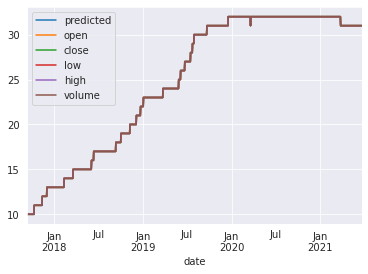

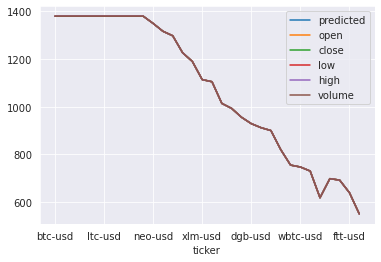

  0%|          | 0/32 [00:00<?, ?it/s]

loading data into cerebro 


NameError: name 'SignalData' is not defined

In [11]:
def main():

    cerebro = bt.Cerebro()  # create a "Cerebro" instance
    cash = 10000

    cerebro.broker.addcommissioninfo(CommInfoFractional())
    cerebro.broker.setcash(cash)

    ## get data from disk
    prices, factors = get_eval_data()
    data = factors.join(prices)

    # data.head()
    counts_df = data.groupby('date').count()
    counts_df.plot()
    plt.show()
    data.groupby('ticker').count().plot()
    plt.show()
    # load data into cerebro
    benchmark_btc = bt_adddata(bt_cerebro=cerebro, data=data.swaplevel())

    save_memory = True
    if save_memory:
        data = None
        prices = None
        factors = None

    ### Configure Strategy Backtest

    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    cerebro.addanalyzer(bt.analyzers.SQN, _name='sqn')
    #cerebro.addanalyzer(bt.analyzers.Transactions, _name='transactions')

    n_positions = [30, 32]
    min_positions = [1,]

    print("start backtest")

    cerebro.optstrategy(MLStrategy_relative, verbose=True,
                        min_positions=min_positions,
                        n_positions=n_positions)

    start = time()

    results = cerebro.run(stdstats=False, optreturn=False)
    # ending_value = cerebro.broker.getvalue()
    print(f'Duration: {format_time(time() - start)}')

    #figure = cerebro.plot(iplot=True, volume=False)[0][0]

    # plotting cerebro requires
    # pip uninstall backtrader
    # pip install git+https://github.com/mementum/backtrader.git@0fa63ef4a35dc53cc7320813f8b15480c8f85517#egg=backtrader
    # https://stackoverflow.com/questions/63471764/importerror-cannot-import-name-warnings-from-matplotlib-dates
    #plot = True
    #if plot:
        #cerebro.plot()  # plot the results
        #figure = cerebro.plot(start=datetime.date(2018, 1, 1),
        #                      end=datetime.date(2019, 1, 1), iplot=False)
        #figure.savefig(f'backtrader2.svg')
        #figure.show()

        #cerebro.plot()  # plot the results
        #figure = cerebro.plot(start=datetime.date(2017, 9, 10),
        #                        end=datetime.date(2019, 1, 1))[0][0]
        #figure.savefig(f'cerebro_plot.svg')



    results_kpis = []
    for result in results:
        sqn_dict = result[0].analyzers.getbyname('sqn').get_analysis()
        assert sqn_dict['trades'] > 30
        results_kpis.append(
                    [sqn_dict['sqn'],
                    round(result[0].broker.getvalue()),
                    result[0].p.min_positions,
                    result[0].p.n_positions,
                    result[0]])

    results_kpis.sort(reverse=True)

    best_strategy = results_kpis[0][4]

    results_kpis_df = pd.DataFrame(data=[sublist[:4] for sublist in results_kpis],
                                   columns=['sqn','value','par min_positions','par n_positions'])
    results_kpis_df.head(10)

    fig, ax = plt.subplots(ncols=1, figsize=(6, 6))

    sns.scatterplot(x="par min_positions", y="par n_positions",
                    size="value", hue="sqn", linewidth=0,
                    data=results_kpis_df, ax=ax)

    # prepare pyfolio data from analyzer
    pyfolio_analyzer = best_strategy.analyzers.getbyname('pyfolio')
    returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

    # results[0][0].analyzers.getbyname('tradeanalyzer').print()


    transactions.head(10)

    """
    benchmark = web.DataReader('SP500', 'fred', '2017', '2022').squeeze()
    benchmark = benchmark.resample('D')
    benchmark = benchmark.ffill()
    benchmark = benchmark.dropna()
    benchmark = benchmark.pct_change().tz_localize('UTC')
    benchmark
    """

    benchmark_btc2 = benchmark_btc['close'].pct_change().rename('btc/usd-benchmark')

    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    log_axs=1
    if log_axs:
        axes[0].set_yscale('log')
        axes[1].set_yscale('log')
        benchmark_btc2.add(1).cumprod().plot(ax=axes[0], title='Cumulative Return', label="benchmark btc-usd")
        returns.add(1).cumprod().plot(ax=axes[0], title='Cumulative Return', label='strategy')
    else:
        benchmark_btc2.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return', label="benchmark btc-usd")
        returns.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return', label='strategy')
    axes[0].legend()
    daily_tx = transactions.groupby(level=0)
    longs = daily_tx.value.apply(lambda x: x.where(x>0).sum())
    shorts = daily_tx.value.apply(lambda x: x.where(x<0).sum())
    longs.plot(label='Long', ax=axes[1], title='Positions')
    shorts.plot(ax=axes[1], label='Short')
    positions.cash.plot(ax=axes[1], label='PF Value')
    axes[1].legend()
    sns.despine()
    fig.tight_layout()

    # prepare pyfolio inputs

    returns.to_hdf('backtrader.h5', 'returns')
    positions.to_hdf('backtrader.h5', 'positions')
    transactions.to_hdf('backtrader.h5', 'transactions/')
    gross_lev.to_hdf('backtrader.h5', 'gross_lev')

    returns = pd.read_hdf('backtrader.h5', 'returns')
    positions = pd.read_hdf('backtrader.h5', 'positions')
    transactions = pd.read_hdf('backtrader.h5', 'transactions/')
    gross_lev = pd.read_hdf('backtrader.h5', 'gross_lev')

    pyfolio = pf.create_full_tear_sheet(returns,
                              transactions=transactions,
                              positions=positions,
                              benchmark_rets=benchmark_btc2)


if __name__ == "__main__":
    main()


